In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

pd.options.display.max_columns = None
pd.options.display.max_rows = None

import warnings
warnings.filterwarnings("ignore")

## Getting the data

In [60]:
from os import listdir
from os.path import isfile, join
mypath = './CMS'
files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
len(files)

import re
dates = list(map(lambda x: re.match(r"out-(.*)-skill.txt", x).groups()[0], files))

from io import StringIO
frames = []
for d in dates:
    f = pd.read_csv(StringIO("\n".join(open(f"CMS/out-{d}-skill.txt").read().splitlines()[3:])))
    f["file_name"] = d
    frames.append(f)
final = pd.concat(frames)

final.head(3)
final.shape
#final.to_csv('scheduling.csv', index=False)

,SKILL,Calls_Offered,ASA,Avg_Talk,Avg_ACW,Calls_Aband,Pos_Staffed,%_Svc_Level,Avg_Talk_w/Hold,Calls_Offrd_II,%_Svc_Level_II,Backup_Calls,ACD_Calls,ABN_Calls1,Busy_Calls,Disc_Calls,ACC_Calls,ACD_Time,ACW_Time,ANS_Time,Hold_Time,file_name
0,11,7,00:07:25,00:07:19,00:04:25,2,0.00,0.0,00:07:48,7,0.0,0,5,0,0,0,0,2196,1325,2227,147,16-7-2019-1300
1,12,0,00:00:00,00:00:00,00:00:00,0,0.00,0.0,00:00:00,0,0.0,0,0,0,0,0,0,0,0,0,0,16-7-2019-1300
2,13,14,00:13:41,00:05:18,00:08:47,7,0.01,0.0,00:05:33,14,0.0,0,7,1,0,0,0,2231,3695,5748,100,16-7-2019-1300
3,14,32,00:12:38,00:06:39,00:10:07,11,0.02,0.0,00:07:07,32,0.0,0,13,0,0,8,0,5193,7894,9860,370,16-7-2019-1300
4,15,16,00:13:33,00:06:04,00:02:11,7,0.01,0.0,00:06:42,16,0.0,0,9,1,0,0,0,3284,1180,7323,340,16-7-2019-1300


## Cleaning and Feature Engineering

In [2]:
d = pd.read_csv('./scheduling.csv')

In [3]:
d = d.drop(['Calls_Offrd_II', '%_Svc_Level_II', 'ACD_Time', 'ACW_Time', 'ANS_Time', 'Hold_Time', 'Backup_Calls'], axis=1)
d = d.drop(['ABN_Calls1', 'Disc_Calls', 'Busy_Calls'], axis=1)

d = d.rename(columns={'file_name': 'date'})
d['date'] = pd.to_datetime(d['date'], format="%d-%m-%Y-%H%M") #timestamp
#d['date_month'] = d['date'].dt.month not for this.
d['date_weekday'] = d['date'].dt.weekday_name
d['date_weekday1'] = d['date'].dt.weekday
d['weekend'] = d['date_weekday1'].isin(range(5,7)) #create a binary column weekend
d['date_hour'] = d['date'].dt.hour
d['working_time'] = d['date_hour'].isin(range(9,18)) #create a binary column sleeping hour

d['asa'] = round((pd.to_timedelta(d['ASA']).dt.total_seconds()% 3600)/60, 2) #average speed of ansewer
d['att'] = round((pd.to_timedelta(d['Avg_Talk']).dt.total_seconds()% 3600)/60, 2) #average talk time
d['aacw'] = round((pd.to_timedelta(d['Avg_ACW']).dt.total_seconds()% 3600)/60, 2) #average after call work
d['attt'] = round((pd.to_timedelta(d['Avg_Talk_w/Hold']).dt.total_seconds()% 3600)/60, 2) #average total talk time
d['aht'] = d['attt']-d['att'] #average hold time
d['atc'] = d['attt']+d['aacw'] #average time per customer
d = d.drop(['ASA', 'Avg_Talk', 'Avg_ACW', 'Avg_Talk_w/Hold'], axis=1)
d['calls_answered'] = d['Calls_Offered']-d['Calls_Aband']
d['act_time'] = d['atc']*d['ACD_Calls']
d['actual_time'] = d['atc']*d['calls_answered']
d['prefered_time'] = d['atc']*d['Calls_Offered']
d['delta_time'] = d['prefered_time']-d['actual_time']

from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
d['weekend'] = lb.fit_transform(d['weekend'])
d['working_time'] = lb.fit_transform(d['working_time'])


Questions:
* call_offered - calls received?
* calls_aband - calls that were ignored
* Pos_Staffed - number od agents avaliable to serve the skill
* %_Svc_Level - performance metrics achieved: answer 80% of calls in 20 sec
* ACD_Calls - calls that are rooted to the skill
* ACC_Calls - ACD met the Svc_level
* can i know more about the skills (top 5: 1142, 1240, 1105, 1143, 181) to wwork more on feature engeneering.

In [4]:
d.shape
d.head(3)
len(d['SKILL'].value_counts())
#calls-aband - calls not ansewred
d = d.sort_values(by='date')

(87755, 24)

,SKILL,Calls_Offered,Calls_Aband,Pos_Staffed,%_Svc_Level,ACD_Calls,ACC_Calls,date,date_weekday,date_weekday1,weekend,date_hour,working_time,asa,att,aacw,attt,aht,atc,calls_answered,act_time,actual_time,prefered_time,delta_time
0,11,7,2,0.00,0.0,5,0,2019-07-16 13:00:00,Tuesday,1,0,13,1,7.42,7.32,4.42,7.80,0.48,12.22,5,61.10,61.10,85.54,24.44
1,12,0,0,0.00,0.0,0,0,2019-07-16 13:00:00,Tuesday,1,0,13,1,0.00,0.00,0.00,0.00,0.00,0.00,0,0.00,0.00,0.00,0.00
2,13,14,7,0.01,0.0,7,0,2019-07-16 13:00:00,Tuesday,1,0,13,1,13.68,5.30,8.78,5.55,0.25,14.33,7,100.31,100.31,200.62,100.31


125

In [392]:
for i in d['SKILL'].value_counts().keys()[:21]: #first 20 are present over the whole timeline
    print(i, '\t--->\t', round(d.groupby([d['SKILL']==i])['prefered_time'].sum()[True], 2)) #getting to know which are the most significant
#top 5: 1142, 1240, 1105, 1143, 181


1108 	--->	 1550.27
1143 	--->	 7431.38
1141 	--->	 4964.89
1144 	--->	 2639.64
181 	--->	 6825.46
117 	--->	 1934.83
1139 	--->	 0.0
1107 	--->	 180.81
1230 	--->	 0.0
1231 	--->	 0.0
1104 	--->	 21.1
1147 	--->	 535.76
1105 	--->	 8270.88
18 	--->	 574.91
131 	--->	 0.0
1117 	--->	 42.22
1240 	--->	 13186.03
126 	--->	 2195.78
1106 	--->	 10.46
1109 	--->	 7439.55
1142 	--->	 14227.26


In [477]:
for i in [1142, 181]: #how many calls were recieved for these 2 skills
    print(i, '\t--->\t', round(d.groupby([d['SKILL']==i])['Calls_Offered'].sum()[True], 2))
#d.groupby([d['SKILL']==1142])['Calls_Aband'].sum()
#d.groupby([d['SKILL']==181])['Calls_Aband'].sum()

1142 	--->	 2748
181 	--->	 872


In [5]:
#loading 2 datasets for 2 skills
d1 = d[d['SKILL']==1142][['date','Calls_Offered','calls_answered','prefered_time','actual_time','date_weekday1','weekend','date_hour','working_time','date_weekday','delta_time','Calls_Aband','asa','att','aacw','attt','aht','atc']]
d1 = d1.reset_index()
d1["prefered_time1"] = d1["prefered_time"].map(lambda x: np.log(x) if x>0 else 0)
                                               
d2 = d[d['SKILL']==181][['date','Calls_Offered','calls_answered','prefered_time','actual_time','date_weekday1','weekend','date_hour','working_time','date_weekday','delta_time','Calls_Aband','asa','att','aacw','attt','aht','atc']]
d2 = d2.reset_index()
d2["prefered_time1"] = d2["prefered_time"].map(lambda x: np.log(x) if x>0 else 0)

d1.head(3)
d2.head(3)

,index,date,Calls_Offered,calls_answered,prefered_time,actual_time,date_weekday1,weekend,date_hour,working_time,date_weekday,delta_time,Calls_Aband,asa,att,aacw,attt,aht,atc,prefered_time1
0,10101,2019-06-17 19:30:00,2,2,34.96,34.96,0,0,19,0,Monday,0.0,0,0.05,4.80,12.68,4.80,0.0,17.48,3.554205
1,16009,2019-06-17 20:00:00,2,2,29.76,29.76,0,0,20,0,Monday,0.0,0,0.98,1.38,13.50,1.38,0.0,14.88,3.393165
2,66985,2019-06-17 20:30:00,2,2,7.92,7.92,0,0,20,0,Monday,0.0,0,0.05,1.68,2.28,1.68,0.0,3.96,2.069391


,index,date,Calls_Offered,calls_answered,prefered_time,actual_time,date_weekday1,weekend,date_hour,working_time,date_weekday,delta_time,Calls_Aband,asa,att,aacw,attt,aht,atc,prefered_time1
0,10088,2019-06-17 19:30:00,0,0,0.0,0.0,0,0,19,0,Monday,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,15996,2019-06-17 20:00:00,0,0,0.0,0.0,0,0,20,0,Monday,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,66972,2019-06-17 20:30:00,0,0,0.0,0.0,0,0,20,0,Monday,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Visualisations

In [675]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)

def graph_av_times(data):
    plt.figure(figsize=(25,17));
    ax = plt.subplot(gs[1, :]);
    g = sns.kdeplot(data["asa"], color="red", label='average speed of ansewer')# bins=150);
    #g = sns.kdeplot(data["att"], color="green")#, shade = True);
    g = sns.kdeplot(data["aacw"], color="green", label='average after call work')#, shade = True);
    g = sns.kdeplot(data["attt"], color="blue", label='average total talk time')#, shade = True);
    #g = sns.kdeplot(data["atc"], color="blue")#, shade = True);
    g = sns.kdeplot(data["aht"], color="lightgreen", shade = True, label='average hold time');
    g.set_xlabel('Time in minutes');
    g.set_ylabel("Distributions");
    g.set_title('Total');

    ax = plt.subplot(gs[0, 0]);
    d[d.working_time==False]["asa"]
    g = sns.kdeplot(data[data.working_time==True]["asa"], color="red", label='average speed of ansewer')# bins=150);
    g = sns.kdeplot(data[data.working_time==True]["aacw"], color="green", label='average after call work')#, shade = True);
    g = sns.kdeplot(data[data.working_time==True]["attt"], color="blue", label='average total talk time')#, shade = True);
    g = sns.kdeplot(data[data.working_time==True]["aht"], color="lightgreen", shade = True, label='average hold time');
    g.set_xlabel('Time in minutes');
    g.set_ylabel("Distributions");
    g.set_title('Working hours');

    ax = plt.subplot(gs[0, 1]);
    g = sns.kdeplot(data[data.working_time==False]["asa"], color="red", label='average speed of ansewer')# bins=150);
    g = sns.kdeplot(data[data.working_time==False]["aacw"], color="green", label='average after call work')#, shade = True);
    g = sns.kdeplot(data[data.working_time==False]["attt"], color="blue", label='average total talk time')#, shade = True);
    g = sns.kdeplot(data[data.working_time==False]["aht"], color="lightgreen", shade = True, label='average hold time');
    g.set_xlabel('Time in minutes');
    g.set_ylabel("Distributions");
    g.set_title('Non working hours');
    plt.show;

def graph_timeline(data):
    plt.figure(figsize=(20,13));
    plt.subplot(2,1,1);
    plt.plot(data['date'].unique(), data.groupby(['date'])[["Calls_Aband"]].sum(), color='red', label='not answered calls');
    plt.plot(data['date'].unique(), data.groupby(['date'])[["Calls_Offered"]].sum(), color='blue', label='received calls');
    plt.gcf().autofmt_xdate();
    plt.xlabel('Timeline');
    plt.ylabel("Distributions");
    plt.title('Amount of answered and not answered calls');
    plt.legend();

    plt.subplot(2,1,2);
    plt.plot(data['date'].unique(), data.groupby(['date'])[["delta_time"]].sum(), color='red', label='not answered calls');
    plt.plot(data['date'].unique(), data.groupby(['date'])[["prefered_time"]].sum(), color='blue', label='received calls');
    plt.gcf().autofmt_xdate();
    plt.xlabel('Timeline');
    plt.ylabel("Distributions");
    plt.title('Amount of answered and not answered minutes');
    plt.legend();
    plt.show();
    
def graph3(data,a,b, col, c):
    plt.subplot(a,3,b); #weekday
    g = sns.barplot(y=data.groupby(['date_weekday'])[col].sum(), color='steelblue', x=data.groupby(['date_weekday'])[col].sum().keys(), order=data['date_weekday'].unique());
    g.set_title('Number of {0} by weekday'.format(c));
    b+=1
    plt.subplot(a,3,b); #hour
    g = sns.barplot(y=data.groupby(['date_hour'])[col].sum(), color='steelblue', x=data.groupby(['date_hour'])[col].sum().keys());
    g.set_title('Number of {0} by hour'.format(c));
    b+=1
    plt.subplot(a,3,b); #heatmap
    x = data.groupby(['date_weekday', 'date_hour'])[col].sum().reset_index(name = 'h').pivot(index = 'date_weekday', columns = 'date_hour');
    x.index = pd.CategoricalIndex(x.index, categories=data['date_weekday'].unique())
    x.sort_index(level=0, inplace=True)
    g = sns.heatmap(x,cmap = 'YlGnBu');
    g.set_title('Heatmap of {0} over week'.format(c));

def graph4(data):
    plt.figure(figsize=[30,30]);
    graph3(data, 4, 1, 'Calls_Offered', 'total calls')
    graph3(data, 4, 4, 'prefered_time', 'total minuties')
    graph3(data, 4, 7, 'Calls_Aband', 'calls that were neglected')
    graph3(data, 4, 10, 'delta_time', 'minutes that were neglected')
    plt.show();
    
def graph_time(pred1, pred2, title):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,4))
    ax1.set_title(title)
    ax1.plot(d1["date"].iloc[-336:], pred1, color='red')
    ax1.plot(d1["date"].iloc[-336:], d1["prefered_time"].iloc[-336:], color='green')
    ax2.set_ylabel("Amount of calls")
    
    ax2.plot(d2["date"].iloc[-336:], pred2, color='red')
    ax2.plot(d2["date"].iloc[-336:], d2["prefered_time"].iloc[-336:], color='green')
    ax2.set_xlabel("Date", fontsize=12)
    ax2.set_ylabel("Amount of calls")
    plt.setp(ax2.get_xticklabels(), rotation=90)
    plt.show();


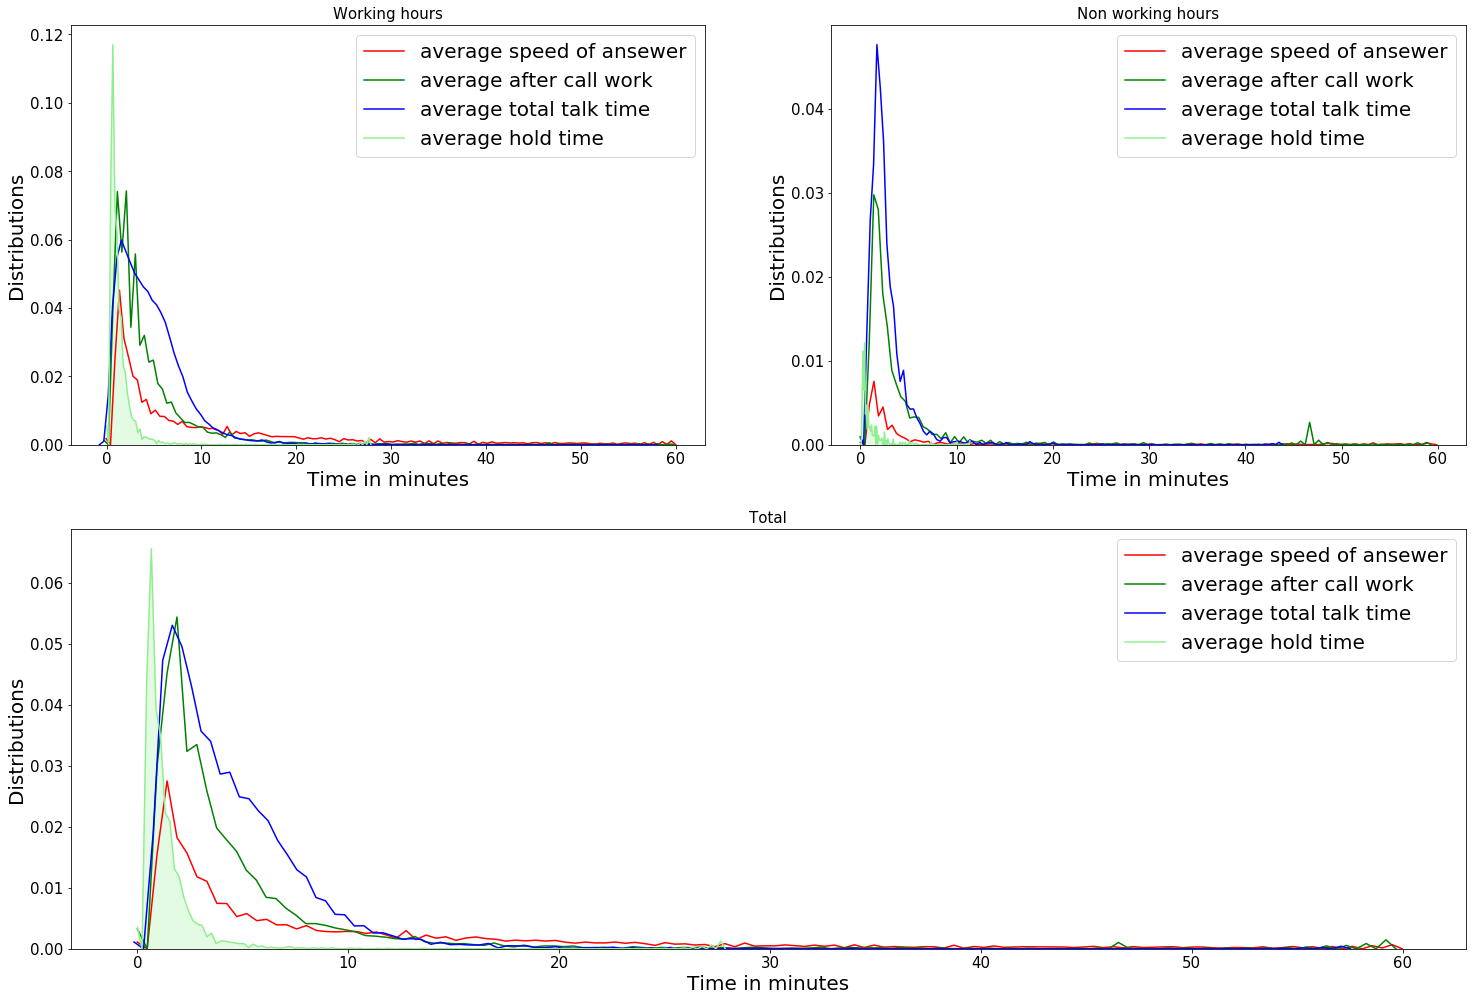

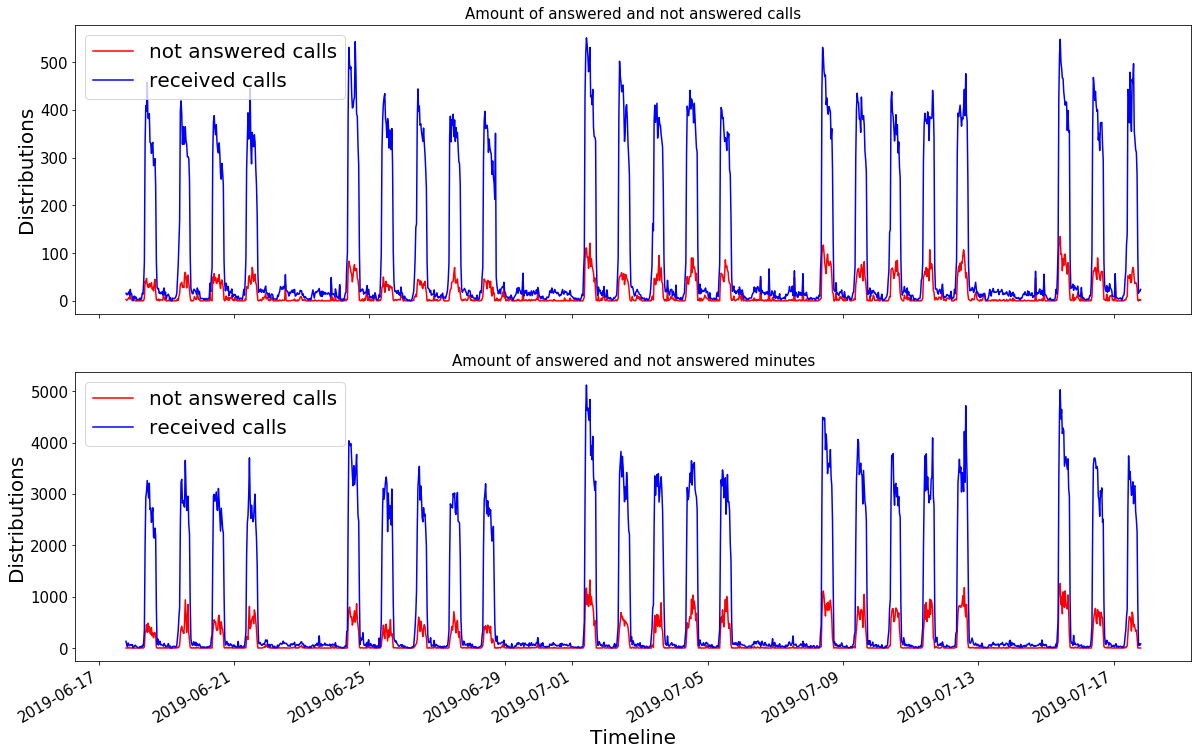

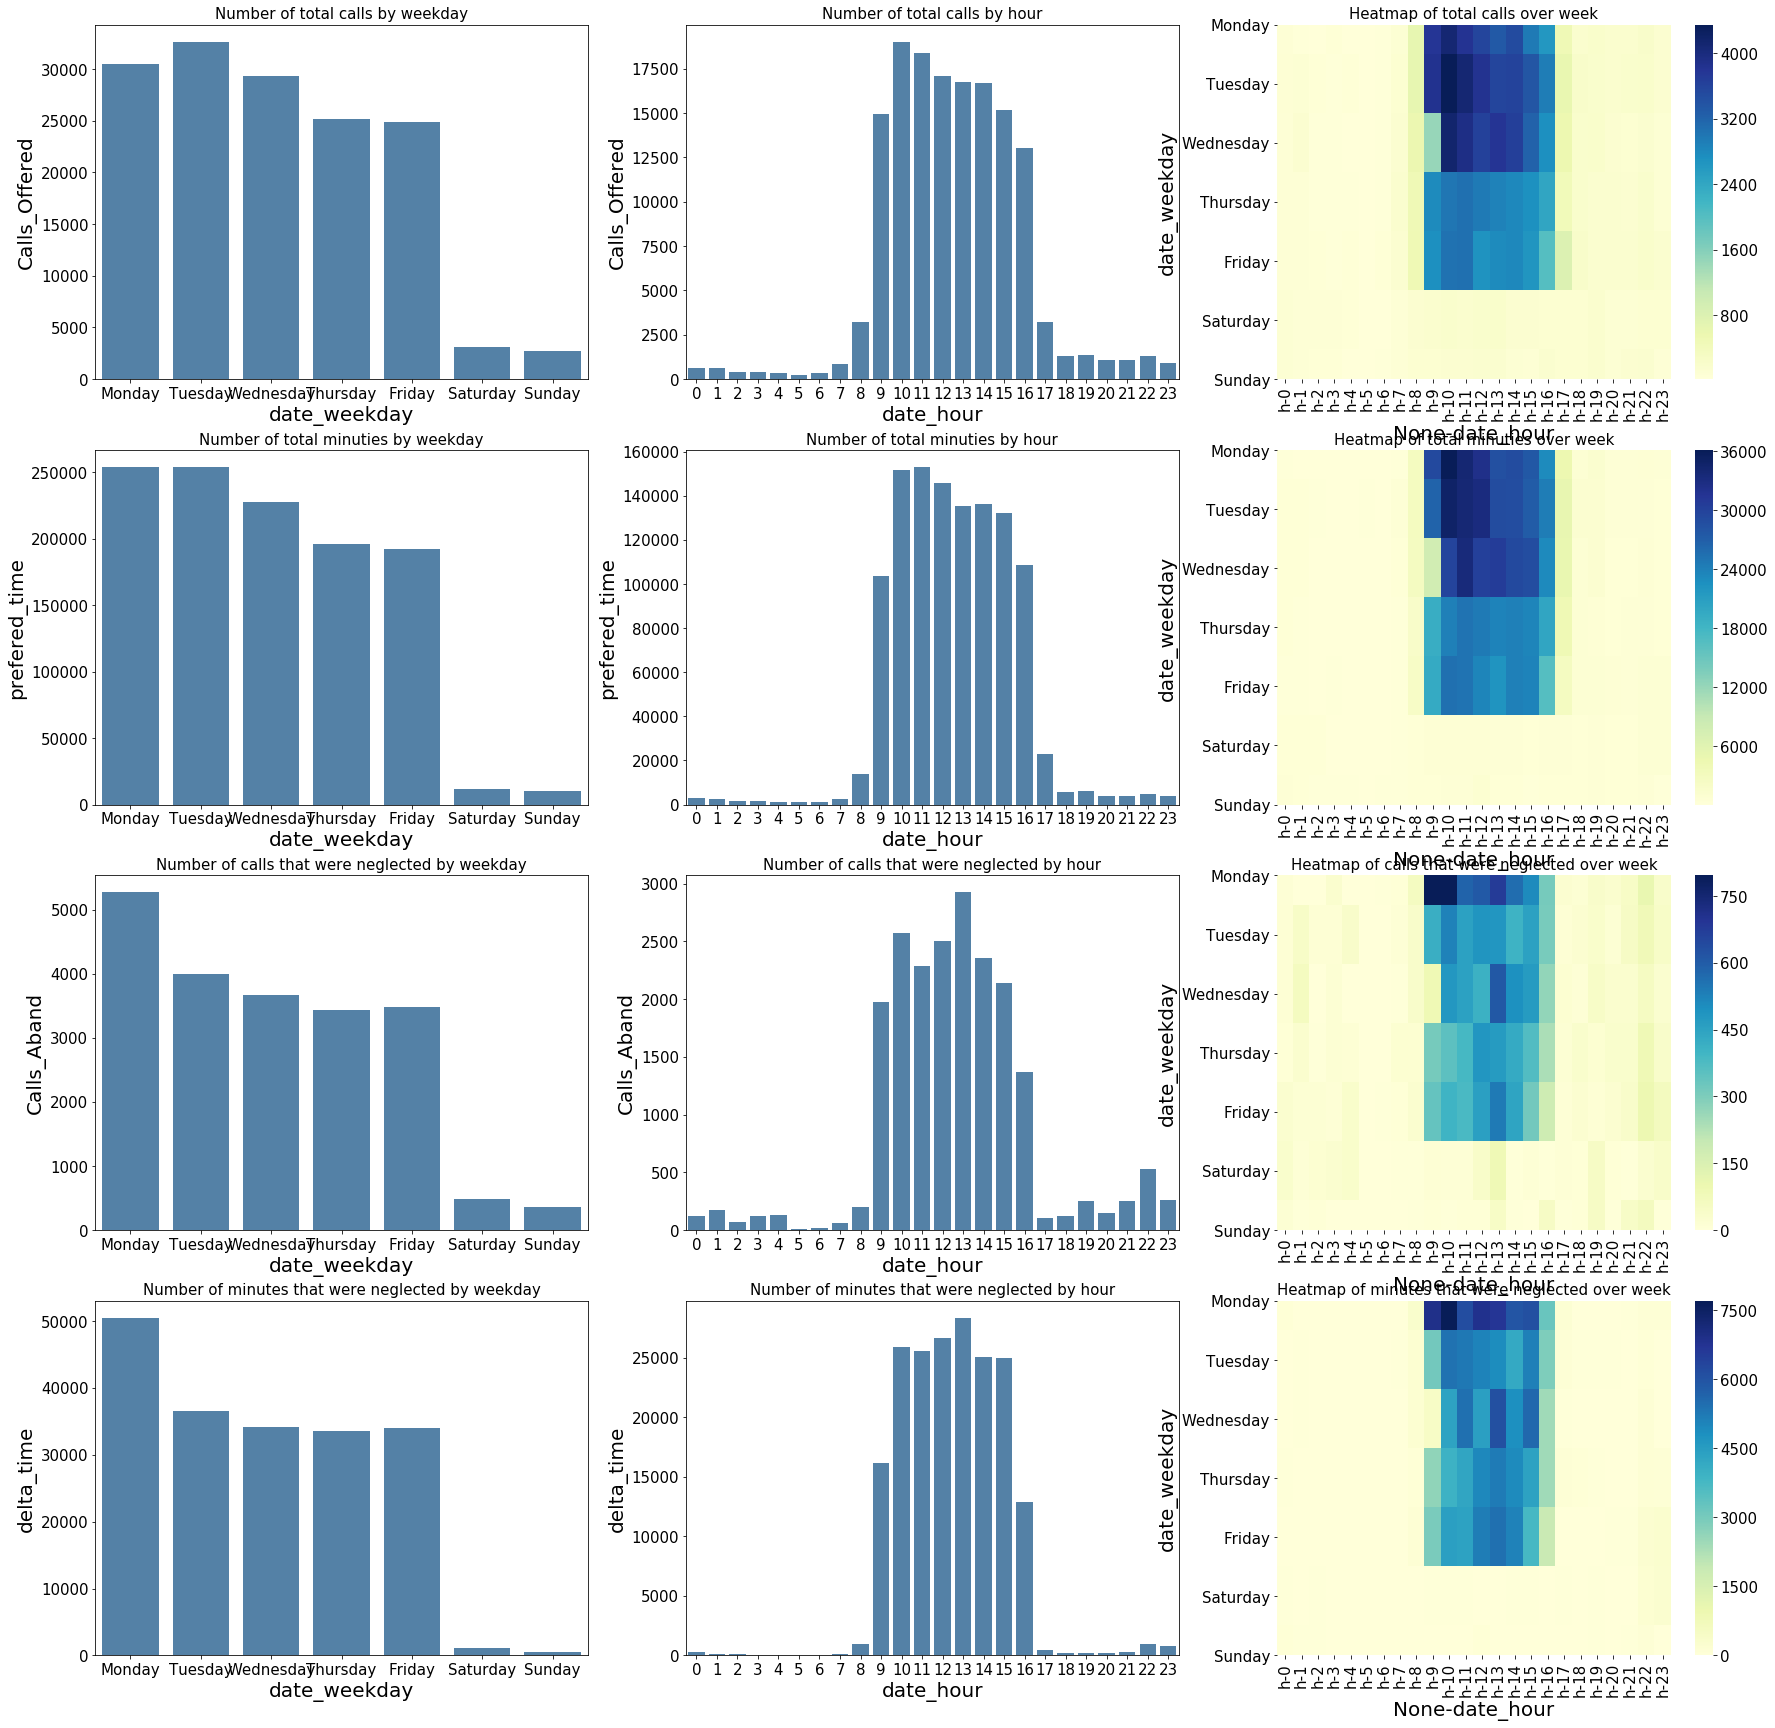

In [676]:
graph_av_times(d)
graph_timeline(d)
graph4(d)

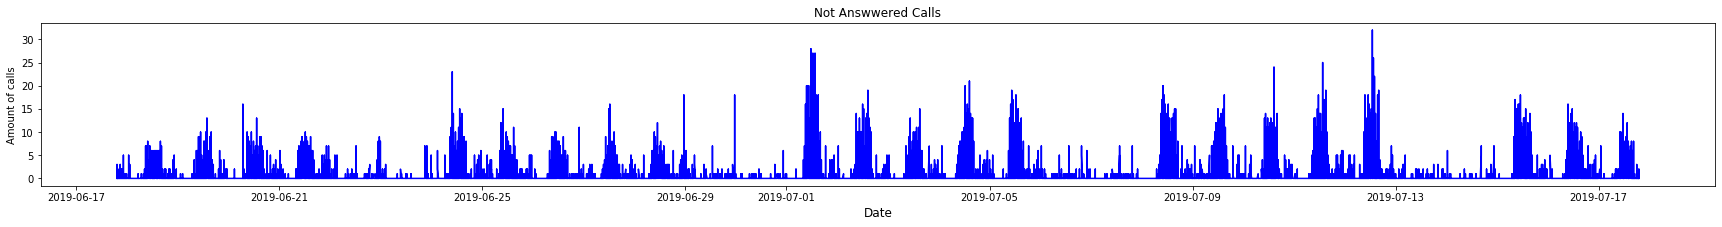

In [429]:
plt.figure(figsize = [30,3]);
plt.title('Not Answwered Calls')
plt.plot(d['date'], d['Calls_Aband'], color='blue')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Amount of calls")
plt.show();

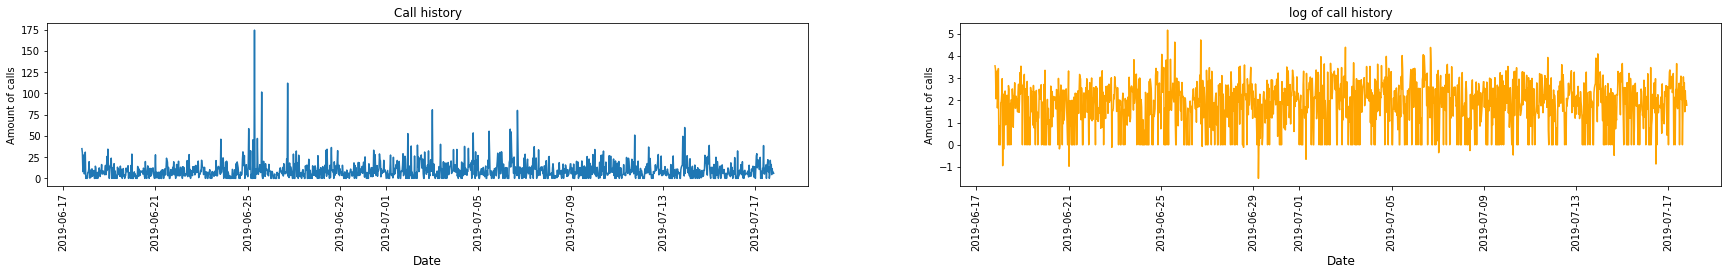

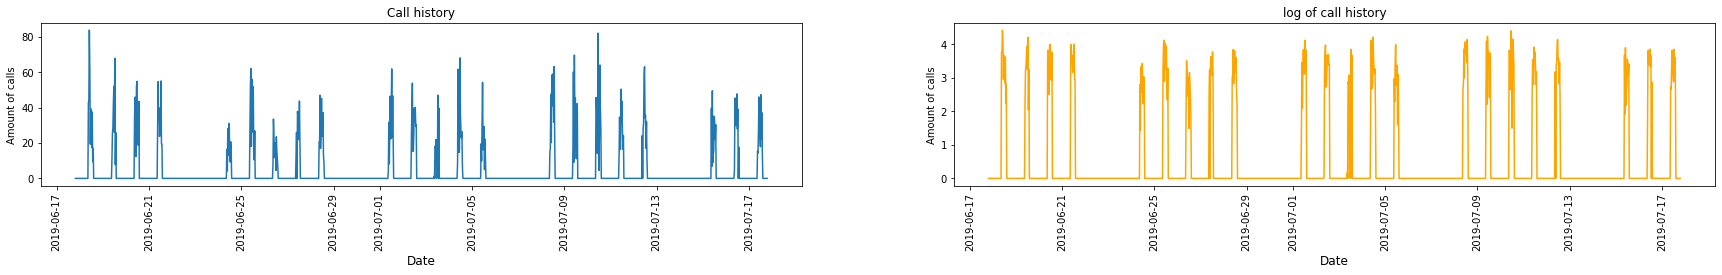

In [7]:
#plots of data and its log
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30,3))
ax1.plot(d1["date"], d1["prefered_time"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Amount of calls")
ax1.set_title("Call history")
plt.setp(ax1.get_xticklabels(), rotation=90)

ax2.plot(d1["date"], d1["prefered_time1"], color="orange")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Amount of calls")
ax2.set_title("log of call history")
plt.setp(ax2.get_xticklabels(), rotation=90)
plt.show();

f, (ax3, ax4) = plt.subplots(1, 2, figsize=(30,3))
ax3.plot(d2["date"], d2["prefered_time"])
ax3.set_xlabel("Date", fontsize=12)
ax3.set_ylabel("Amount of calls")
ax3.set_title("Call history")
plt.setp(ax3.get_xticklabels(), rotation=90)

ax4.plot(d2["date"], d2["prefered_time1"], color="orange")
ax4.set_xlabel("Date", fontsize=12)
ax4.set_ylabel("Amount of calls")
ax4.set_title("log of call history")
plt.setp(ax4.get_xticklabels(), rotation=90)
plt.show();

## Time Series Analysis

In [6]:
#Dickey-Fuller test to check for stationary data
from statsmodels.tsa.stattools import adfuller

def adfuller_test(data):
    #Perform Dickey-Fuller test:
    print ('Results of for Dickey-Fuller Test:')
    testing = adfuller(data, autolag='AIC')
    output = pd.Series(testing[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in testing[4].items():
        output['Critical Value (%s)'%key] = value
    print (output)

#apply adf test on the series
adfuller_test(d1['prefered_time'])
print('')
adfuller_test(d2['prefered_time'])

# d1 - unit root, non stationary, time dependent structure
# d2 - no unit root, stationary


Results of for Dickey-Fuller Test:
Test Statistic                -1.660199e+01
p-value                        1.761195e-29
#Lags Used                     3.000000e+00
Number of Observations Used    1.436000e+03
Critical Value (1%)           -3.434912e+00
Critical Value (5%)           -2.863555e+00
Critical Value (10%)          -2.567843e+00
dtype: float64

Results of for Dickey-Fuller Test:
Test Statistic                -9.803157e+00
p-value                        5.921025e-17
#Lags Used                     1.600000e+01
Number of Observations Used    1.423000e+03
Critical Value (1%)           -3.434954e+00
Critical Value (5%)           -2.863573e+00
Critical Value (10%)          -2.567852e+00
dtype: float64


In [6]:
#performance measure
from math import sqrt
from sklearn.metrics import mean_squared_error
def rmse(test, predictions):
    return round(sqrt(mean_squared_error(test, predictions)), 3)


In [7]:
pm_rmse = pd.DataFrame(columns=['model', 'result: skill 1142', 'result: skill 181'])
pm_rmse['model'] = ['Naive Forecast: last week','Naive Forecast: last day','fbprophet',
                    'ARIMA: (3,0,2)','RandomForest','GradientBoosting',
                   'ExtraTree','LSTM']
pm_rmse = pm_rmse.set_index('model')

In [550]:
def graph_time1(pred1, pred2, title):
    f, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,4))
    ax1.set_title(title)
    ax1.plot(d1["date"].iloc[-336:], pred1, color='red')
    ax1.plot(d1["date"].iloc[-336:], d1["Calls_Offered"].iloc[-336:], color='green')
    ax2.set_ylabel("Amount of calls")
    
    ax2.plot(d2["date"].iloc[-336:], pred2, color='red')
    ax2.plot(d2["date"].iloc[-336:], d2["Calls_Offered"].iloc[-336:], color='green')
    ax2.set_xlabel("Date", fontsize=12)
    ax2.set_ylabel("Amount of calls")
    plt.setp(ax2.get_xticklabels(), rotation=90)
    plt.show();

### Naive Forecast

In [405]:
nf_day = pd.concat([d1['prefered_time'].shift(48)[48:], d2['prefered_time'].shift(48)[48:], d2['date'][0:]], axis=1)
nf_day.columns = ['d1','d2','date']
nf_day = nf_day.dropna(subset=['d2']) 
pm_rmse.loc['Naive Forecast: last day']['result: skill 1142'] = rmse(d1[-336:]['prefered_time'],nf_day[-336:]['d1'])
pm_rmse.loc['Naive Forecast: last day']['result: skill 181'] = rmse(d2[-336:]['prefered_time'],nf_day[-336:]['d2'])

nf_week = pd.concat([d1['prefered_time'].shift(336)[336:], d2['prefered_time'].shift(336)[336:], d2['date'][0:]], axis=1)
nf_week.columns = ['d1','d2','date']
nf_week = nf_week.dropna(subset=['d2']) 
pm_rmse.loc['Naive Forecast: last week']['result: skill 1142'] = rmse(d1[-336:]['prefered_time'],nf_week[-336:]['d1'])
pm_rmse.loc['Naive Forecast: last week']['result: skill 181'] = rmse(d2[-336:]['prefered_time'],nf_week[-336:]['d2'])


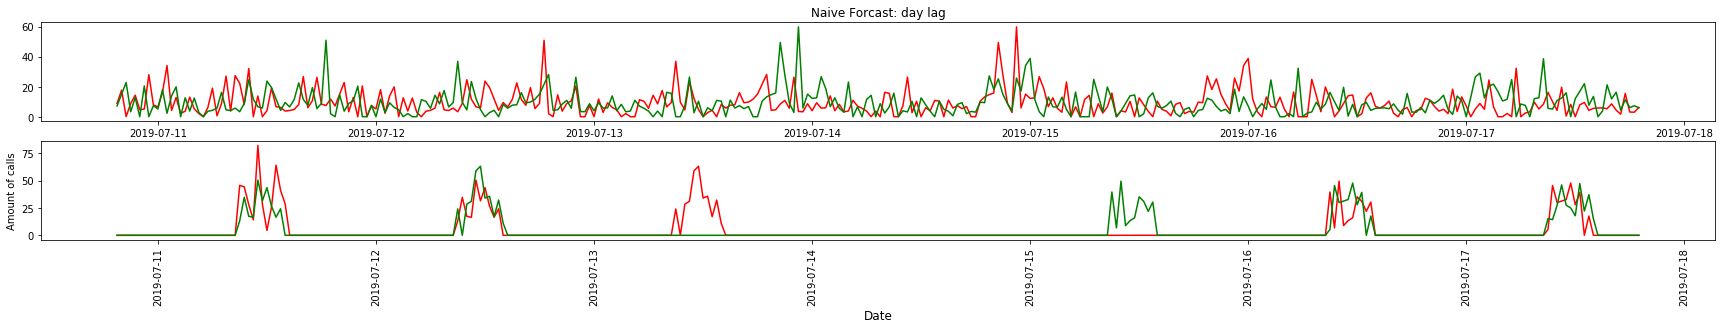

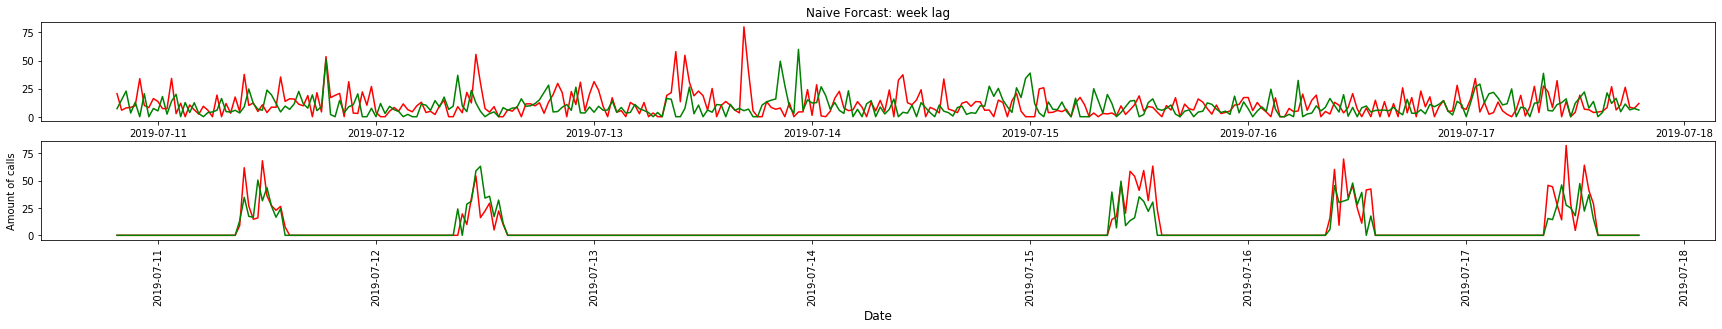

In [453]:
graph_time(nf_day[-336:]['d1'], nf_day[-336:]['d2'], 'Naive Forcast: day lag')
graph_time(nf_week[-336:]['d1'], nf_week[-336:]['d2'], 'Naive Forcast: week lag')

In [411]:
pm_rmse.loc['Naive Forecast: last day']
pm_rmse.loc['Naive Forecast: last week']

result: skill 1142    11.997
result: skill 181     11.021
Name: Naive Forecast: last day, dtype: object

result: skill 1142    13.856
result: skill 181      9.148
Name: Naive Forecast: last week, dtype: object

### Prophet

In [412]:
#getting the data
df1 = d1[['date','prefered_time']]
df1 = df1.set_index('date').resample('H').sum().reset_index()
df1 = df1.drop(0)
df1 = df1.rename(columns={'date': 'ds', 'prefered_time': 'y'})
df1['y'] = df1['y'].map(lambda x: np.log(x) if x>0 else 0)
df1['ds'] = df1['ds'].astype(str)
#split11 = int(0.7 * len(df1))
train11, test11 = df1.iloc[:-168].reset_index(), df1.iloc[-168:].reset_index()


df2 = d2[['date','prefered_time']]
df2 = df2.set_index('date').resample('H').sum().reset_index()
df2 = df2.drop(0)
df2 = df2.rename(columns={'date': 'ds', 'prefered_time': 'y'})
df2['y'] = df2['y'].map(lambda x: np.log(x) if x>0 else 0)
df2['ds'] = df2['ds'].astype(str)
#split22 = int(0.7 * len(df2))
train22, test22 = df2.iloc[:-168].reset_index(), df2.iloc[-168:].reset_index()

d1.shape, df1.shape, train11.shape, test11.shape
test11.head(3)

((1440, 20), (720, 2), (552, 3), (168, 3))

,index,ds,y
0,553,2019-07-10 20:00:00,3.633895
1,554,2019-07-10 21:00:00,2.778198
2,555,2019-07-10 22:00:00,3.019937


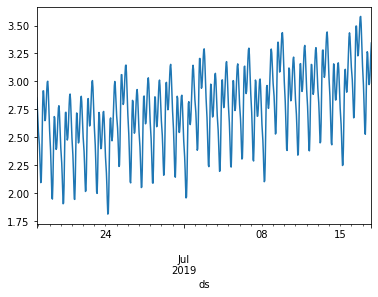

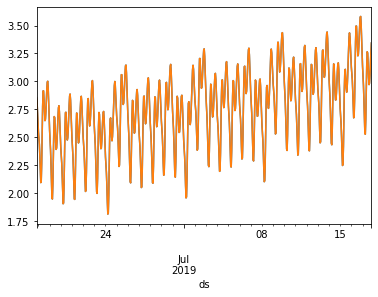

In [72]:
pd.plotting.register_matplotlib_converters()
try:
    forecast1.set_index('ds').yhat.plot().get_figure()
except TypeError as e:
    figure_or_exception = str("TypeError: " + str(e))
else:
    figure_or_exception = forecast1.set_index('ds').yhat.plot().get_figure()
 

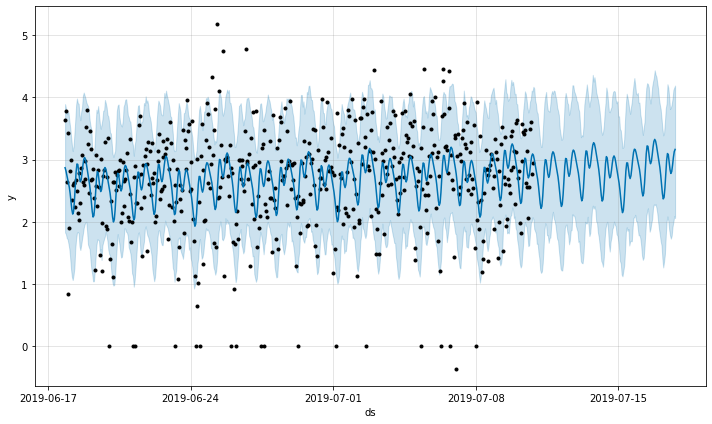

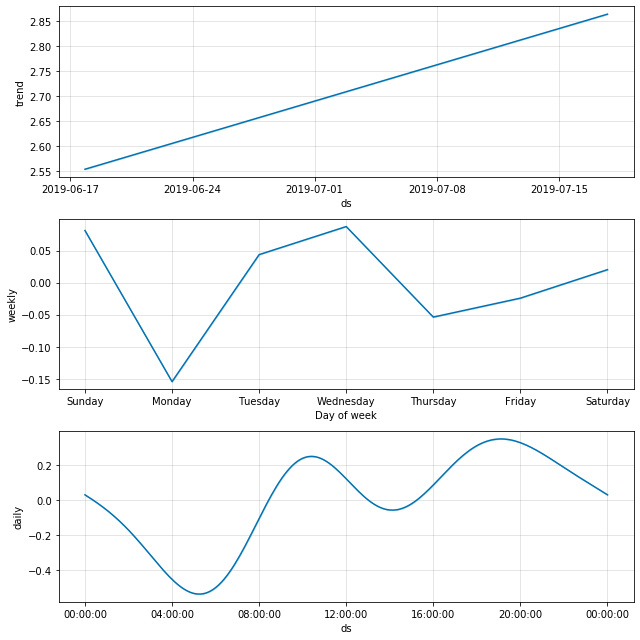

In [414]:
from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.01, yearly_seasonality=False).fit(train11)
future1 = m.make_future_dataframe(periods=168, freq='H')
forecast1 = m.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

fig1 = m.plot(forecast1)
fig1 = m.plot_components(forecast1)
plt.show();


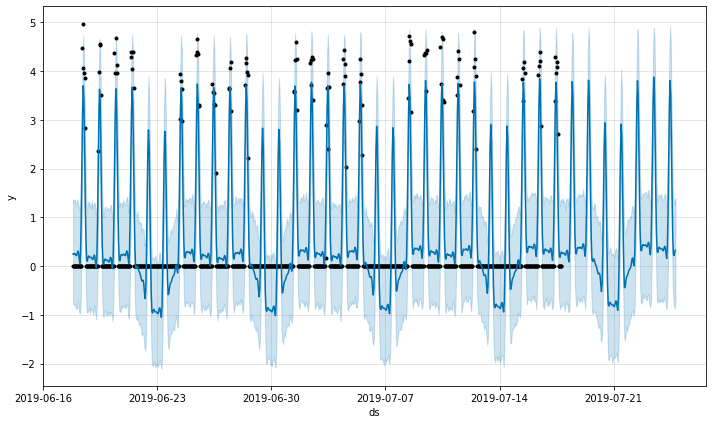

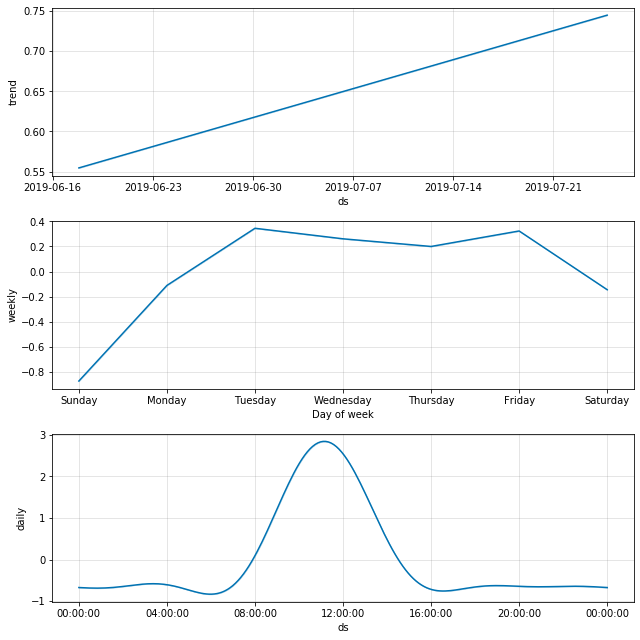

In [415]:
m = Prophet(changepoint_prior_scale=0.01, yearly_seasonality=False).fit(df2)
future2 = m.make_future_dataframe(periods=168, freq='H')
forecast2 = m.predict(future2)
forecast2[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3)

fig1 = m.plot(forecast2)
fig1 = m.plot_components(forecast2)
plt.show();

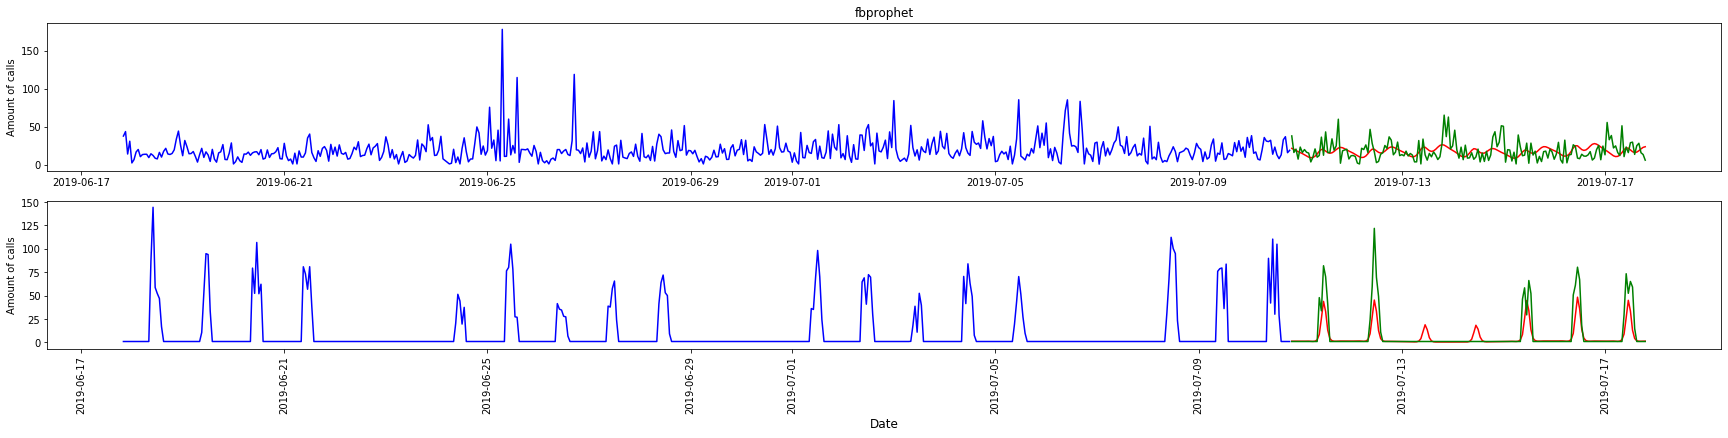

In [416]:
df1['ds'] = pd.to_datetime(df1['ds'], format="%Y-%m-%d %H:%M:%S")
df2['ds'] = pd.to_datetime(df2['ds'], format="%Y-%m-%d %H:%M:%S")
#'2019-06-17 20:00:00'
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(30,6))
ax1.set_title('fbprophet')
ax1.plot(df1.iloc[:552]['ds'], np.exp(train11['y']), color='blue')
ax1.plot(df1.iloc[552:]['ds'], np.exp(forecast1[-168:]['yhat']), color='red')
ax1.plot(df1.iloc[552:]['ds'], np.exp(test11['y']), color='green')
ax1.set_ylabel("Amount of calls")

ax2.plot(df1.iloc[:552]['ds'], np.exp(train22['y']), color='blue')
ax2.plot(df1.iloc[552:]['ds'], np.exp(forecast2[-168:]['yhat']), color='red')
ax2.plot(df1.iloc[552:]['ds'], np.exp(test22['y']), color='green')
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Amount of calls")
plt.setp(ax2.get_xticklabels(), rotation=90)
plt.show();

In [417]:
pm_rmse.loc['fbprophet']['result: skill 1142'] = rmse(np.exp(test11['y']),np.exp(forecast1[-168:]['yhat']))
pm_rmse.loc['fbprophet']['result: skill 181'] = rmse(np.exp(test22['y']),np.exp(forecast2[-168:]['yhat']))
pm_rmse.loc['fbprophet']

result: skill 1142    12.909
result: skill 181     13.852
Name: fbprophet, dtype: object

### ARIMA

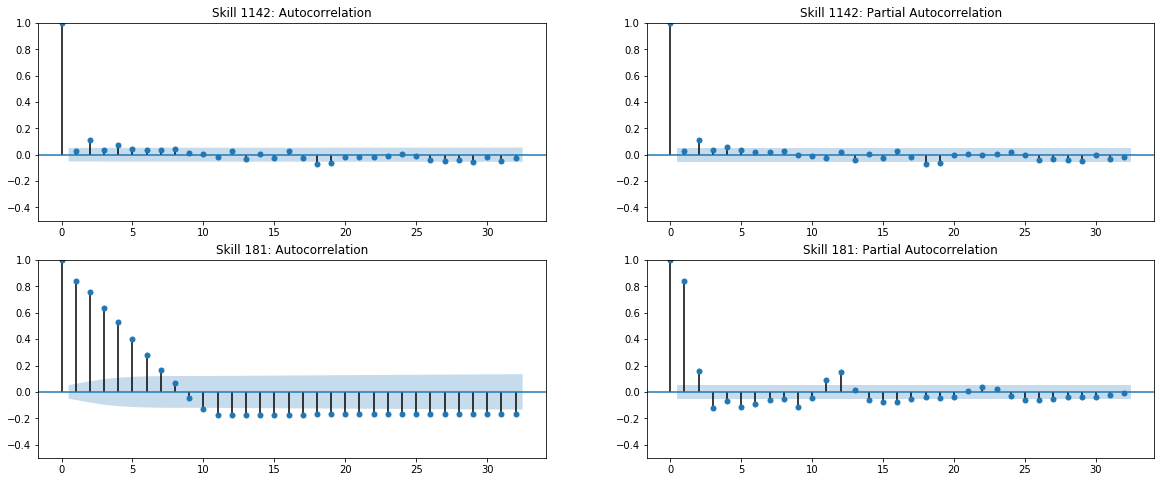

In [82]:
# In ACF and PACF, identifying lags will help determine ARIMA parameters
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 

plt.figure(figsize=(20,8))
plt.subplot(221);
plt.ylim([-0.5,1])
plot_acf(d1['prefered_time1'], ax=plt.gca())
plt.title('Skill 1142: Autocorrelation')
plt.subplot(222);
plt.ylim([-0.5,1])
plot_pacf(d1['prefered_time1'], ax=plt.gca())
plt.title('Skill 1142: Partial Autocorrelation')

plt.subplot(223);
plt.ylim([-0.5,1])
plot_acf(d2['prefered_time1'], ax=plt.gca())
plt.title('Skill 181: Autocorrelation')
plt.subplot(224);
plt.ylim([-0.5,1])
plot_pacf(d2['prefered_time1'], ax=plt.gca())
plt.title('Skill 181: Partial Autocorrelation')
plt.show();

In [418]:
skil1142 = pd.Series(d1['prefered_time1'].values , index=d1['date'])
skil1142.index = pd.DatetimeIndex(skil1142.index.values, freq = skil1142.index.inferred_freq)
X1 = skil1142.values
X1 = X1.astype('float32')
#split1 = int(len(X1) * 0.70)
train1, test1 = X1[0:1104], X1[1104:]

skill181 = pd.Series(d2['prefered_time1'].values , index=d2['date'])
skill181.index = pd.DatetimeIndex(skill181.index.values, freq = skill181.index.inferred_freq)
X2 = skill181.values
X2 = X2.astype('float32')
#split2 = int(len(X2) * 0.70)
train2, test2 = X2[0:1104], X2[1104:]


In [419]:
from statsmodels.tsa.arima_model import ARIMA
yhat1 = []
history = [x for x in train1]
for t in range(len(test1)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat1.append(yhat)
    history.append(test1[t])

yhat2 = []
history = [x for x in train2]
for t in range(len(test2)):
    model = ARIMA(history, order=(3,0,2))
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat2.append(yhat)
    history.append(test2[t])


In [450]:
yhat21 = pd.DataFrame(data = yhat1, columns=['yhat1'], index=skil1142.index[1104:])
yhat22 = pd.DataFrame(data = yhat2, columns=['yhat2'], index=skill181.index[1104:])


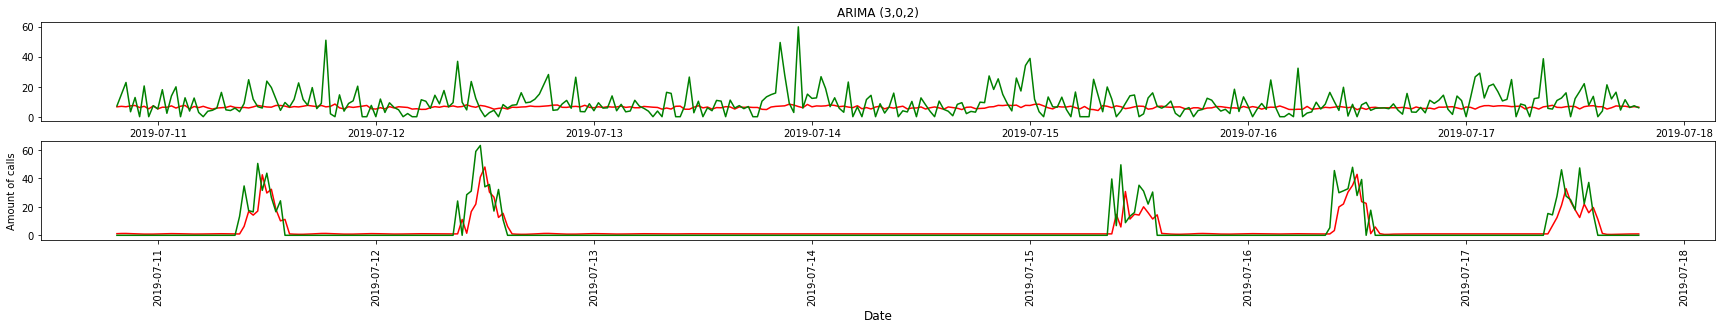

In [454]:
graph_time(np.exp(yhat21), np.exp(yhat22), 'ARIMA (3,0,2)')


In [422]:
pm_rmse.loc['ARIMA: (3,0,2)']['result: skill 1142'] = rmse(np.exp(test1),np.exp(yhat1))
pm_rmse.loc['ARIMA: (3,0,2)']['result: skill 181'] = rmse(np.exp(test2),np.exp(yhat2))
pm_rmse.loc['ARIMA: (3,0,2)']

result: skill 1142    9.011
result: skill 181     7.368
Name: ARIMA: (3,0,2), dtype: object

### Ensamble models: Random Forest, Gradient Boosting, Extra Tree

In [612]:
#spliting data into train/test
#split1 = int(0.7 * len(d1))
d11 = d1[['date','prefered_time','prefered_time1','date_weekday1','weekend','date_hour','working_time']]
d11 = d11.set_index(['date'])
train_x1, test_x1, train_y1, test_y1 = d11[['date_weekday1','weekend','date_hour','working_time']].iloc[:1104], d11[['date_weekday1','weekend','date_hour','working_time']].iloc[1104:], d11['prefered_time1'].iloc[:1104], d11['prefered_time1'].iloc[1104:]
train_x1.shape, test_x1.shape, train_y1.shape, test_y1.shape
d11.head(4)

#split2 = int(0.7 * len(d1))
d22 = d2[['date','prefered_time','prefered_time1','date_weekday1','weekend','date_hour','working_time']]
d22 = d22.set_index(['date'])
train_x2, test_x2, train_y2, test_y2 = d22[['date_weekday1','weekend','date_hour','working_time']].iloc[:1104], d22[['date_weekday1','weekend','date_hour','working_time']].iloc[1104:], d22['prefered_time1'].iloc[:1104], d22['prefered_time1'].iloc[1104:]


((1104, 4), (336, 4), (1104,), (336,))

,prefered_time,prefered_time1,date_weekday1,weekend,date_hour,working_time
date,,,,,,
2019-06-17 19:30:00,34.96,3.554205,0,0,19,0
2019-06-17 20:00:00,29.76,3.393165,0,0,20,0
2019-06-17 20:30:00,7.92,2.069391,0,0,20,0
2019-06-17 21:00:00,16.02,2.773838,0,0,21,0


In [627]:
from sklearn.ensemble import RandomForestRegressor
model1 = RandomForestRegressor(n_estimators=10).fit(train_x1, train_y1)
yhat7 = model1.predict(test_x1)
model2 = RandomForestRegressor().fit(train_x2, train_y2)
yhat8 = model2.predict(test_x2)

from sklearn.ensemble import GradientBoostingRegressor
model2 = GradientBoostingRegressor().fit(train_x1, train_y1)
yhat3 = model1.predict(test_x1)
model2 = RandomForestRegressor().fit(train_x2, train_y2)
yhat4 = model2.predict(test_x2)

from sklearn.ensemble import ExtraTreesRegressor
model3 = ExtraTreesRegressor().fit(train_x1, train_y1)
yhat5 = model1.predict(test_x1)
model2 = RandomForestRegressor().fit(train_x2, train_y2)
yhat6 = model2.predict(test_x2)


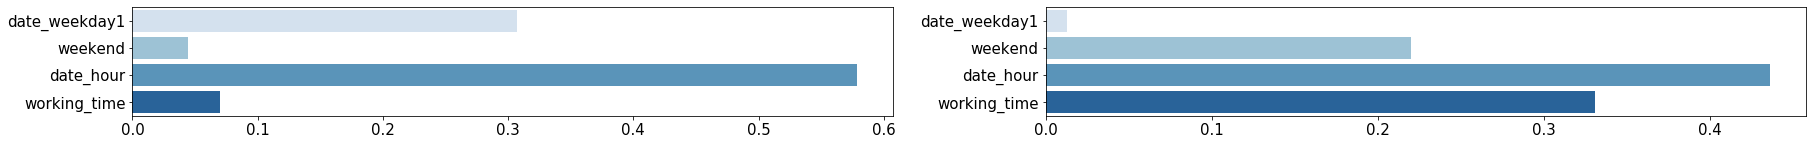

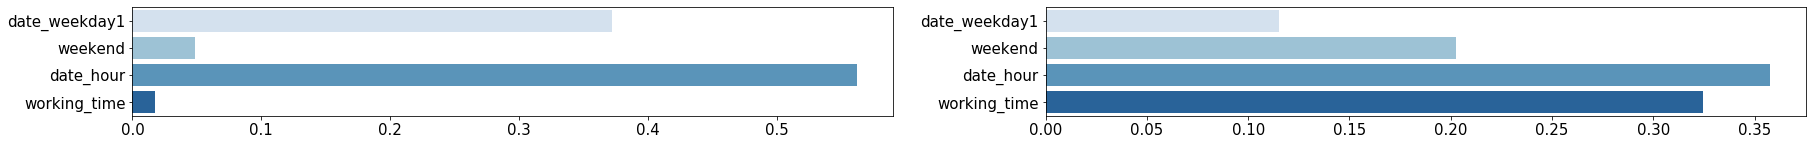

In [535]:
plt.figure(figsize=(30,2))
plt.title("Feature importance for RandomForest")
plt.subplot(1,2,1)
sns.barplot(y=train_x1.columns.values, x = model1.fit(train_x1,train_y1).feature_importances_, orient='h',
           palette='Blues')
plt.subplot(1,2,2)
sns.barplot(y=train_x2.columns.values, x = model1.fit(train_x2,train_y2).feature_importances_, orient='h',
           palette='Blues')
plt.show();

plt.figure(figsize=(30,2))
plt.title("Feature importance for RandomForest")
plt.subplot(1,2,1)
sns.barplot(y=train_x1.columns.values, x = model2.fit(train_x1,train_y1).feature_importances_, orient='h',
           palette='Blues')
plt.subplot(1,2,2)
sns.barplot(y=train_x2.columns.values, x = model2.fit(train_x2,train_y2).feature_importances_, orient='h',
           palette='Blues')
plt.show();



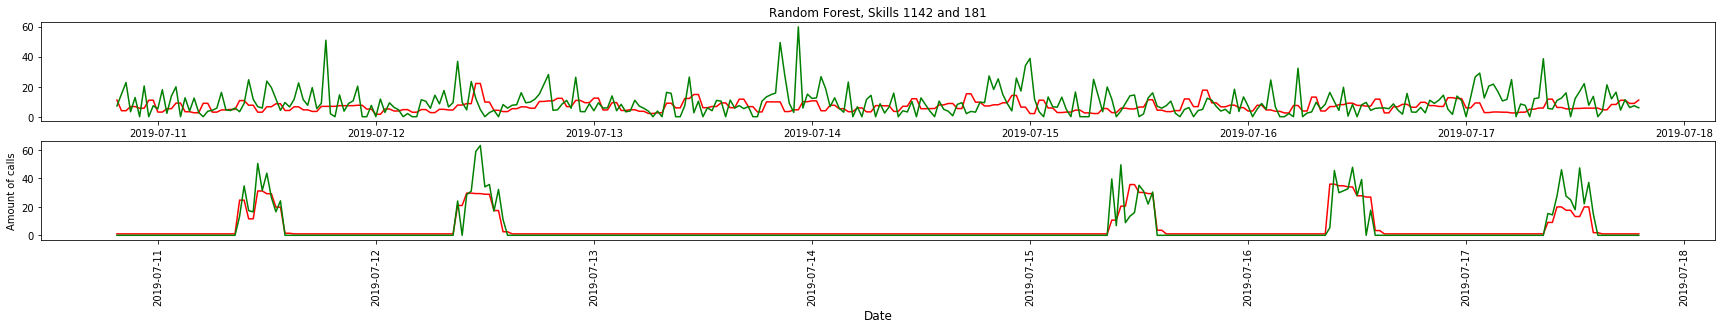

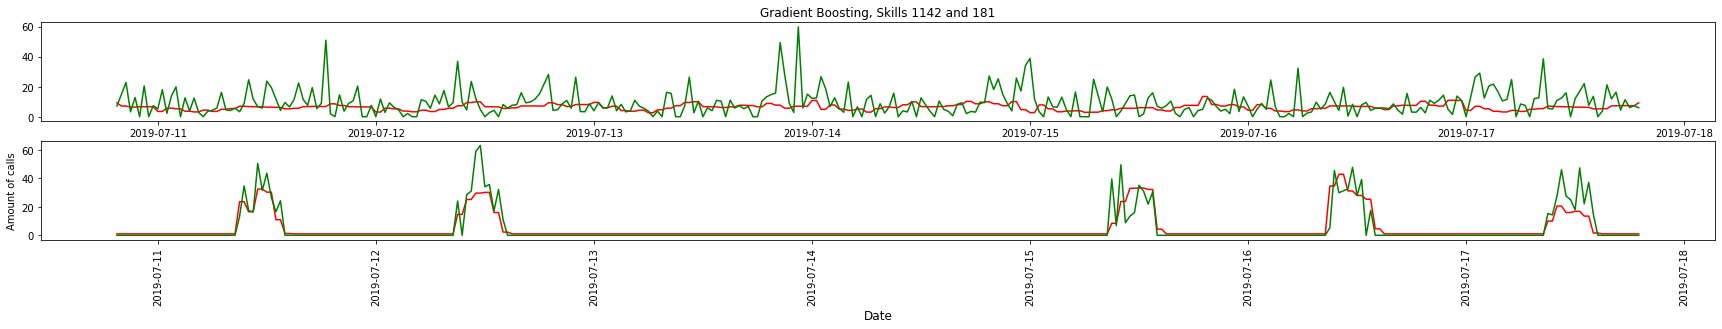

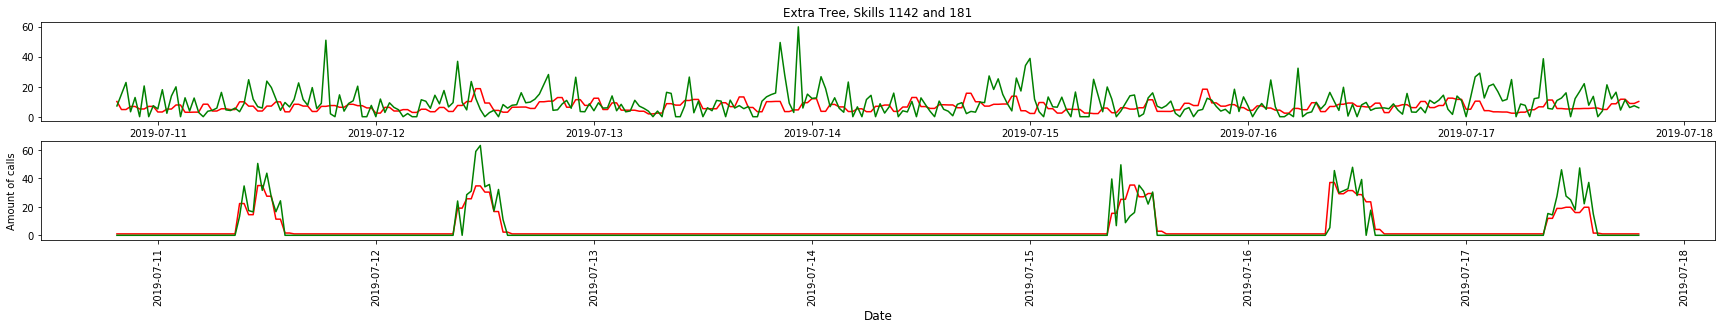

In [456]:
graph_time(np.exp(yhat7), np.exp(yhat8), 'Random Forest, Skills 1142 and 181')
graph_time(np.exp(yhat3), np.exp(yhat4), 'Gradient Boosting, Skills 1142 and 181')
graph_time(np.exp(yhat5), np.exp(yhat6), 'Extra Tree, Skills 1142 and 181')


In [426]:
pm_rmse.loc['RandomForest']['result: skill 1142'] = rmse(np.exp(test_y1),np.exp(yhat7))
pm_rmse.loc['RandomForest']['result: skill 181'] = rmse(np.exp(test_y2),np.exp(yhat8))
pm_rmse.loc['RandomForest']

pm_rmse.loc['GradientBoosting']['result: skill 1142'] = rmse(np.exp(test_y1),np.exp(yhat3))
pm_rmse.loc['GradientBoosting']['result: skill 181'] = rmse(np.exp(test_y2),np.exp(yhat4))
pm_rmse.loc['GradientBoosting']

pm_rmse.loc['ExtraTree']['result: skill 1142'] = rmse(np.exp(test_y1),np.exp(yhat5))
pm_rmse.loc['ExtraTree']['result: skill 181'] = rmse(np.exp(test_y2),np.exp(yhat6))
pm_rmse.loc['ExtraTree']

result: skill 1142    9.429
result: skill 181     5.597
Name: RandomForest, dtype: object

result: skill 1142    9.204
result: skill 181     5.492
Name: GradientBoosting, dtype: object

result: skill 1142    9.407
result: skill 181     5.666
Name: ExtraTree, dtype: object

### Multivariate time series forecasting with NN (LSTM)

In [432]:
# Working with data
# df = d1[['date','date_weekday1','weekend','date_hour','working_time','prefered_time1']]
# df['prefered_time2'] = d2['prefered_time1']

df1 = pd.concat([d1[['date','date_weekday1','weekend','date_hour','working_time','prefered_time1']],d1['prefered_time1'].shift(48)[48:],d1['prefered_time1'].shift(336)[336:]], axis=1)#, d1['prefered_time1'].shift(96)[96:],d1['prefered_time1'].shift(144)[144:]], axis=1)
df1 = df1.set_index(['date'])
df1.columns = ['date_weekday1','weekend','date_hour','working_time','prefered_time1(t-336)','prefered_time1(t-48)','prefered_time1(t)']#,'prefered_time1(t-48)','prefered_time1(t)']
df1 = df1.dropna(subset=['prefered_time1(t)'])

df2 = pd.concat([d2[['date','date_weekday1','weekend','date_hour','working_time','prefered_time1']],d2['prefered_time1'].shift(336)[336:], d2['prefered_time1'].shift(672)[672:]], axis=1)
df2 = df2.set_index(['date'])
df2.columns = ['date_weekday1','weekend','date_hour','working_time','prefered_time1(t-672)','prefered_time1(t-336)','prefered_time1(t)']
df2 = df2.dropna(subset=['prefered_time1(t)'])
df1.shape, df2.shape #(1296, 8) (768, 7)


((1104, 7), (768, 7))

In [536]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
def network_model(data, parameter_to_estemate, a, b, c):
    # Spliting and spaping the data
    split = int(0.5 * len(data)) #Note: change the split for the faster model training
    train, val, test = data[:split], data[split:-336], data[-336:]
    train_X, train_y = train.values[:, :len(train.columns)-1], train.values[:, -1]
    val_X, val_y = val.values[:, :len(train.columns)-1], val.values[:, -1]
    test_X, test_y = test.values[:, :len(train.columns)-1], test.values[:, -1]

    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    # design network
    model = Sequential()
    model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, train_y, epochs=c, batch_size=72, validation_data=(val_X, val_y), verbose=2, shuffle=False)
    # make a prediction
    yhat = model.predict(val_X)
    yhat1 = model.predict(test_X)
    val_X = val_X.reshape((val_X.shape[0], len(val.columns)-1)) #change to have same dimentions
    test_X = test_X.reshape((test_X.shape[0], len(test.columns)-1)) #change to have same dimentions

    # calculate RMSE
    pm_rmse.loc['LSTM'][a] = rmse(np.exp(test_y), np.exp(yhat1))
    
    #graph
    plt.figure(figsize = (30,3))
    plt.plot(data.index[split:-336], np.exp(yhat), color='red')
    plt.plot(data.index[split:-336], np.exp(val_y), color='lightblue')
    plt.plot(data.index[-336:], np.exp(yhat1), color='red')
    plt.plot(data.index[-336:], np.exp(test_y), color='green')
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Amount of calls")
    plt.xticks(rotation=90)
    plt.show();


Train on 552 samples, validate on 216 samples
Epoch 1/15
 - 9s - loss: 1.3349 - val_loss: 1.3419
Epoch 2/15
 - 0s - loss: 1.1784 - val_loss: 1.1898
Epoch 3/15
 - 0s - loss: 1.0525 - val_loss: 1.0638
Epoch 4/15
 - 0s - loss: 0.9571 - val_loss: 0.9574
Epoch 5/15
 - 0s - loss: 0.8940 - val_loss: 0.8854
Epoch 6/15
 - 0s - loss: 0.8644 - val_loss: 0.8559
Epoch 7/15
 - 0s - loss: 0.8582 - val_loss: 0.8482
Epoch 8/15
 - 0s - loss: 0.8572 - val_loss: 0.8462
Epoch 9/15
 - 0s - loss: 0.8534 - val_loss: 0.8456
Epoch 10/15
 - 0s - loss: 0.8505 - val_loss: 0.8454
Epoch 11/15
 - 0s - loss: 0.8486 - val_loss: 0.8443
Epoch 12/15
 - 0s - loss: 0.8469 - val_loss: 0.8428
Epoch 13/15
 - 0s - loss: 0.8454 - val_loss: 0.8418
Epoch 14/15
 - 0s - loss: 0.8439 - val_loss: 0.8411
Epoch 15/15
 - 0s - loss: 0.8427 - val_loss: 0.8406


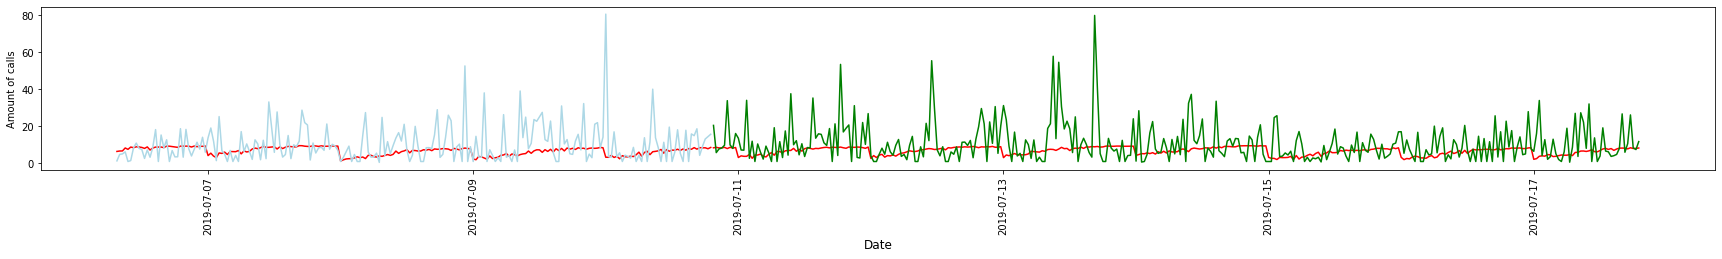

In [460]:
network_model(df1, 'prefered_time1(t)', 'result: skill 1142', 0, 15)


Train on 384 samples, validate on 48 samples
Epoch 1/50
 - 9s - loss: 0.7560 - val_loss: 0.7202
Epoch 2/50
 - 0s - loss: 0.6176 - val_loss: 0.6211
Epoch 3/50
 - 0s - loss: 0.5994 - val_loss: 0.6288
Epoch 4/50
 - 0s - loss: 0.5825 - val_loss: 0.5911
Epoch 5/50
 - 0s - loss: 0.5349 - val_loss: 0.5747
Epoch 6/50
 - 0s - loss: 0.5162 - val_loss: 0.5536
Epoch 7/50
 - 0s - loss: 0.4970 - val_loss: 0.5421
Epoch 8/50
 - 0s - loss: 0.4830 - val_loss: 0.5210
Epoch 9/50
 - 0s - loss: 0.4668 - val_loss: 0.5023
Epoch 10/50
 - 0s - loss: 0.4552 - val_loss: 0.4901
Epoch 11/50
 - 0s - loss: 0.4442 - val_loss: 0.4761
Epoch 12/50
 - 0s - loss: 0.4351 - val_loss: 0.4598
Epoch 13/50
 - 0s - loss: 0.4224 - val_loss: 0.4478
Epoch 14/50
 - 0s - loss: 0.4112 - val_loss: 0.4310
Epoch 15/50
 - 0s - loss: 0.3972 - val_loss: 0.4183
Epoch 16/50
 - 0s - loss: 0.3865 - val_loss: 0.3957
Epoch 17/50
 - 0s - loss: 0.3707 - val_loss: 0.3766
Epoch 18/50
 - 0s - loss: 0.3545 - val_loss: 0.3582
Epoch 19/50
 - 0s - loss: 0.

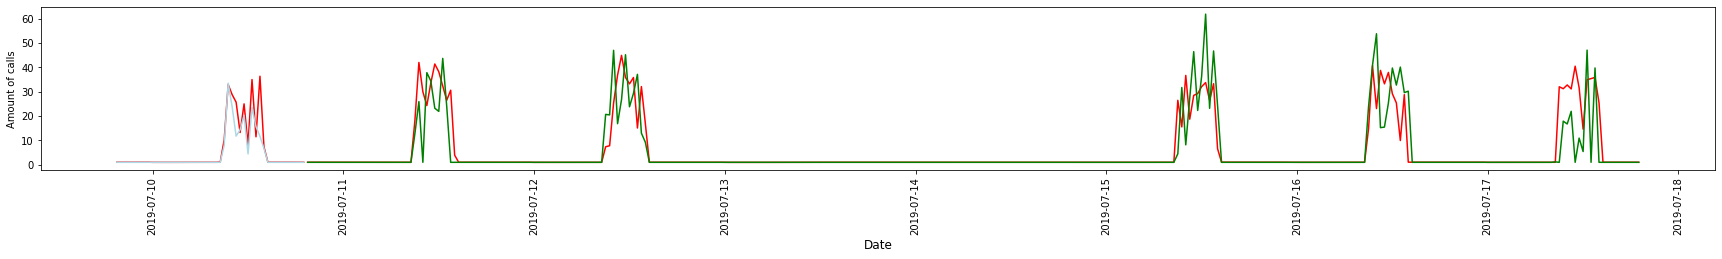

In [461]:
network_model(df2, 'prefered_time1(t)', 'result: skill 181', 0, 50)


In [443]:
pm_rmse.loc['LSTM']

result: skill 1142    11.201
result: skill 181      7.617
Name: LSTM, dtype: object

## Results

In [516]:
a = pm_rmse.loc[['Naive Forecast: last week','Naive Forecast: last day','fbprophet','ARIMA: (3,0,2)','RandomForest','GradientBoosting','LSTM']]
a

,result: skill 1142,result: skill 181
model,,
Naive Forecast: last week,13.856,9.148
Naive Forecast: last day,11.997,11.021
fbprophet,12.909,13.852
"ARIMA: (3,0,2)",9.011,7.368
RandomForest,9.429,5.597
GradientBoosting,9.204,5.492
LSTM,11.236,7.389
